# Course Project: Galaxy Classifier

### Lexy Andershock, Gian Fernandez-Aleman, David Long

#### Introduction
This course project for our Intro to Machine Learning course (COSC325) utilizes a Stochastic Gradient Descent model, a Random Forest Generator model and a K-Nearest Neighbor model on a dataset of colored galaxy images (Galaxy10 SDSS). While the dataset was originally used with a CNN (a more appropriate model for image data), we wanted to experiment and see what we could do with it using a few of the learning techniques we've learned in class.

#### Who is this for?
Our target audience for this project would include astronomers, physicists, space enthusiasts, space researchers, educators, and general populations with an interest in galaxy-shape indentification.

#### Purpose of the Project
The problem we are trying to solve is identifying the shapes of newly discovered galaxies. This dataset contains 10 unique categories of different-shaped galaxies, and we want to train models to be able to assign one of these categories to new images of galaxies it hasn't encountered yet. With new space telescopes such as JWST, we are discovering new galaxies at an accelerating rate, and being able to quickly classify them for studying would be very useful instead of manually doing it. This would make users' lives significantly better as they can have a system that handles massive amounts of galaxy photosets and produces accurate results, which is more time-efficient as opposed to manually determining the galaxy shapes.

### 1. Setting Up The Environment
We must ensure that we have imported all the appropriate libraries that we will utilize for our data manipulation and modeling.

In [1]:
# Import required libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

# Scikit-learn libraries and routines
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

### 2. Downloading and Extracting Data + Showing Some Galaxies From Each Label
We then download and extract our data from the dataset and organize them into two separate categories: images and labels. One image from each galaxy label is shown for reference

File already downloaded.


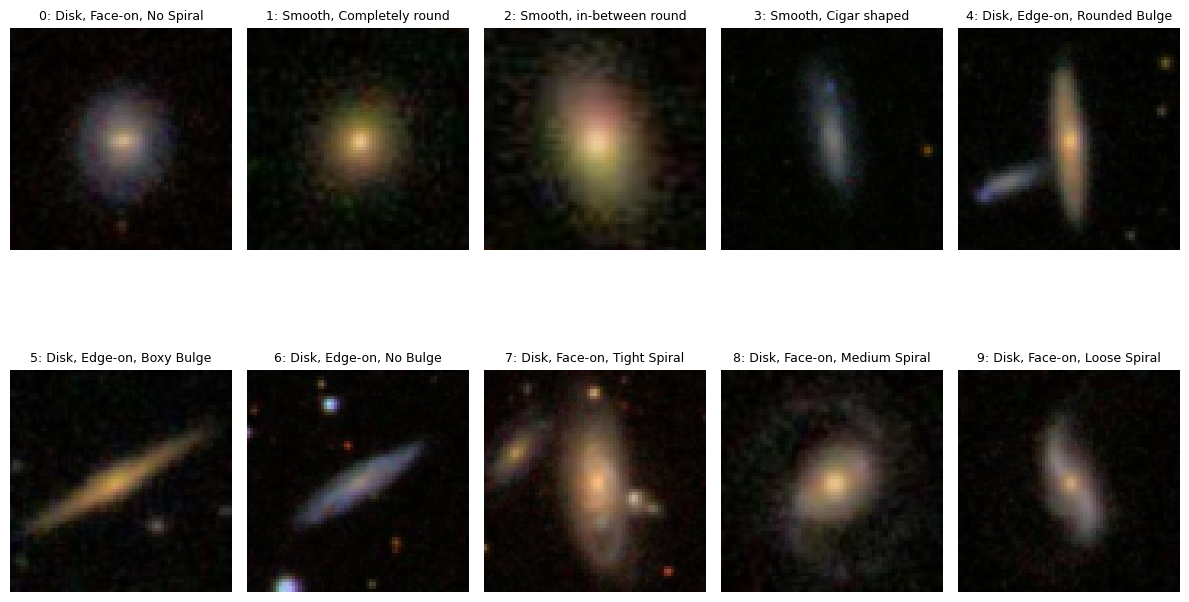

In [2]:
# Document how to download + import the dataset
url = "https://zenodo.org/records/10844811/files/Galaxy10.h5"
file_name = "Galaxy10.h5"

response = requests.get(url, stream=True)
if os.path.exists("Galaxy10.h5"):
    print("File already downloaded.")
else:
    with open(file_name, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete!")

# To get the images and labels from file
with h5py.File(file_name, 'r') as data:
    images = np.array(data['images'])
    labels = np.array(data['ans'])

label_names = [
        "Disk, Face-on, No Spiral",
        "Smooth, Completely round",
        "Smooth, in-between round",
        "Smooth, Cigar shaped",
        "Disk, Edge-on, Rounded Bulge",
        "Disk, Edge-on, Boxy Bulge",
        "Disk, Edge-on, No Bulge",
        "Disk, Face-on, Tight Spiral",
        "Disk, Face-on, Medium Spiral",
        "Disk, Face-on, Loose Spiral"
    ]        

# Find one sample per unique label
unique_classes = np.unique(labels)
class_examples = []

for class_id in unique_classes:
    idx = np.where(labels == class_id)[0][0]
    class_examples.append((images[idx], class_id))

# Plot in 5 rows of 2
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
axes = axes.flatten()

for i, (img, label) in enumerate(class_examples):
    axes[i].imshow(img)
    axes[i].set_title(f"{label}: {label_names[label]}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### 3. Processing Data
We then process our data. In this case, we'll flatten the color images and normalize the pixel values

In [3]:
# Flatten images
n_samples, height, width, channels = images.shape
X = images.reshape(n_samples, height * width * channels)
y = labels

# Normalize pixel values between 0 and 1
X = X.astype(np.float32) / 255.0

### 4. Splitting Data
Once we have the data put into separate categories, we split it into training and testing categories.

In [4]:
# Shuffle the full dataset before splitting
X, y = shuffle(X, y, random_state = 42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, stratify = y, random_state = 42)

### 5. Scaling Features
We'll scale the features

In [5]:
# Create and fit the scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA after scaling
pca = PCA(n_components = 1500)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### 6. Training The Model!
We'll start training the Stochastic Gradient Descent regression model

In [6]:
# Train the model using Stochastic Gradient Descent
model = OneVsRestClassifier(SGDClassifier(loss = 'log_loss', max_iter = 5000))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss', max_iter=5000))

### 7. Predicting Using The Model
We'll predict on the test set using the model we just trained

Model Accuracy : 0.34

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.52      0.31       346
           1       0.41      0.20      0.27       700
           2       0.42      0.46      0.44       629
           3       0.10      0.06      0.07        35
           4       0.59      0.44      0.50       153
           5       0.00      0.00      0.00         2
           6       0.60      0.44      0.51        59
           7       0.29      0.13      0.18       112
           8       0.30      0.14      0.19        91
           9       0.15      0.08      0.10        52

    accuracy                           0.34      2179
   macro avg       0.31      0.25      0.26      2179
weighted avg       0.38      0.34      0.33      2179



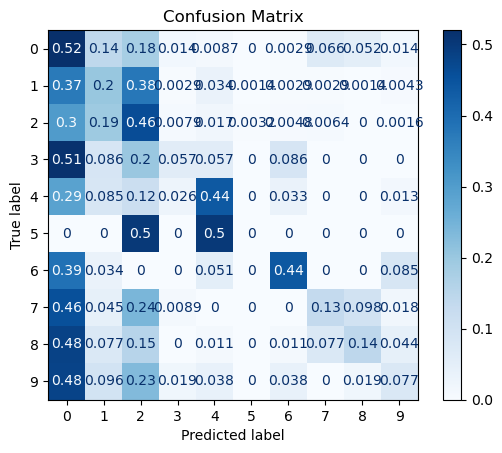

In [7]:
# Predict on the test set
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy : {accuracy:.2f}\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

cm_test = confusion_matrix(y_test, y_pred, normalize='true')

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Reset model for learning curve
model = OneVsRestClassifier(SGDClassifier(loss='log_loss', max_iter=300))

# Set up learning curve
train_sizes = np.linspace(0.1, 1.0, 5)  # only 3 points
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y,
    train_sizes=train_sizes,
    cv=2,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

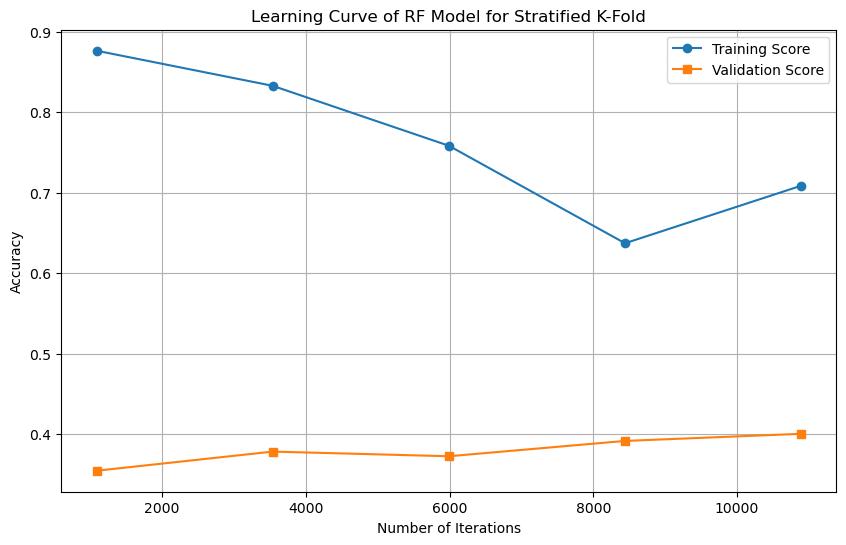

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='s')
plt.title("Learning Curve of RF Model for Stochastic Gradient Descent")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 8. Model #2: Random Forest
For our second model, we decided to use a random forest.

In [10]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Stratified K-Fold RF Model
To combat overfitting, we used a stratified K-Fold.

In [11]:
# Stratified K-Fold Data (Overfitting Mitigation)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd

# initialize model
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)

# k-stratified data
skf = StratifiedKFold(n_splits = 10, random_state=42, shuffle=True)

# adjust X and y
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y[0]

# Calculate accuracy
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index, :]
    X_test = X.iloc[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    # evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold Accuracy: {accuracy}')

print(f'\nAverage Accuracy: {sum(accuracy_scores) / len(accuracy_scores)}')

Fold Accuracy: 0.67691601652134
Fold Accuracy: 0.6741624598439652
Fold Accuracy: 0.6668196420376319
Fold Accuracy: 0.6622303809086737
Fold Accuracy: 0.6636071592473611
Fold Accuracy: 0.6735537190082644
Fold Accuracy: 0.67722681359045
Fold Accuracy: 0.679981634527089
Fold Accuracy: 0.6648301193755739
Fold Accuracy: 0.6639118457300276

Average Accuracy: 0.6703239790790377


In [12]:
# Learning curve for kfold (6 minutes)
y = pd.Series(y)  # Convert y to a Series instead of DataFrame

# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and std
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

KeyboardInterrupt: 

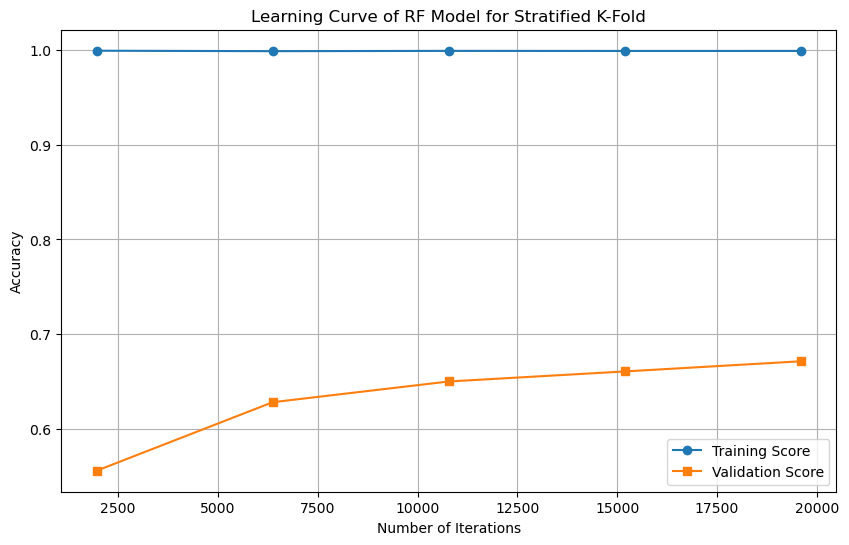

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='s')
plt.title("Learning Curve of RF Model for Stratified K-Fold")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#### Normal Random Forest
This is how our random forest model performed with no overfitting mitigation.

In [ ]:
# Non-Mititgated Data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       346
           1       0.74      0.93      0.82       700
           2       0.72      0.70      0.71       629
           3       0.25      0.09      0.13        35
           4       0.74      0.74      0.74       153
           5       0.00      0.00      0.00         2
           6       0.67      0.73      0.70        59
           7       0.34      0.19      0.24       112
           8       0.14      0.03      0.05        91
           9       0.33      0.02      0.04        52

    accuracy                           0.66      2179
   macro avg       0.44      0.39      0.39      2179
weighted avg       0.62      0.66      0.63      2179

Confusion Matrix:


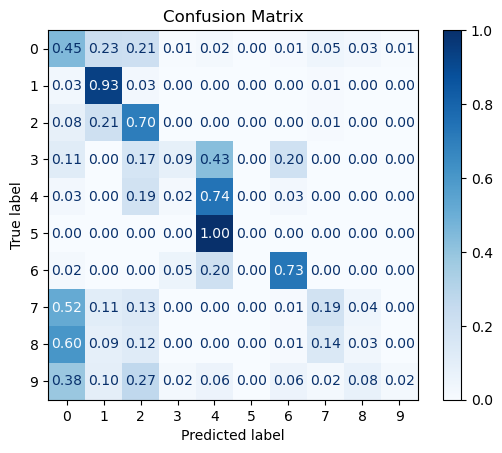

In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=rf_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Learning Curve for non-mitigated data
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='accuracy')

# Mean and std deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

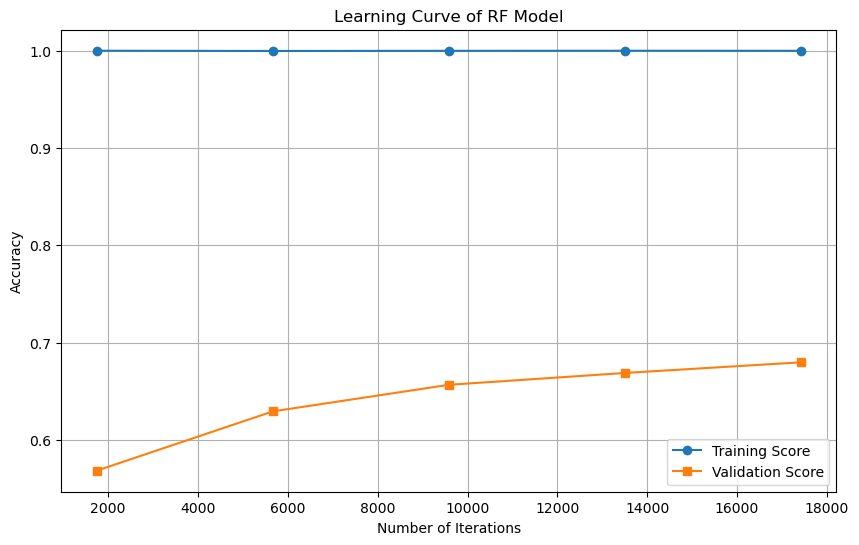

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='s')
plt.title("Learning Curve of RF Model")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameter Tuning of Random Forest Model
This function shows what the hyperparameters should be set to for the best accuracy.

In [ ]:
# # Try classification of data.

# from sklearn.model_selection import train_test_split, GridSearchCV

# # Step 1: Split into training + testing (we'll do CV on training only)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 2: Define model and parameter grid
# model = RandomForestClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [20, 30, 70],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# # Step 3: GridSearch with Cross-Validation
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,                    # 5-fold cross-validation
#     scoring='accuracy',     # or 'f1', 'roc_auc', etc.
#     n_jobs=-1,               # Use all processors
#     verbose=1
# )

# grid_search.fit(X_train, y_train)

# # Step 4: Best model and parameters
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# # Step 5: Evaluate on test data
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", test_accuracy)

### 9. Model #3: K-Nearest Neighbors
For our third model, we decided to use K-Nearest Neighbors.

In [ ]:
# Import Libraries
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Create model
knn_model = KNeighborsClassifier(n_neighbors = 5)

# Fit to data
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

KNN Model Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.29      0.35       346
           1       0.68      0.94      0.79       700
           2       0.70      0.77      0.73       629
           3       0.21      0.17      0.19        35
           4       0.73      0.66      0.69       153
           5       0.00      0.00      0.00         2
           6       0.80      0.61      0.69        59
           7       0.35      0.17      0.23       112
           8       0.29      0.02      0.04        91
           9       0.00      0.00      0.00        52

    accuracy                           0.65      2179
   macro avg       0.42      0.36      0.37      2179
weighted avg       0.59      0.65      0.60      2179

Confusion Matrix:


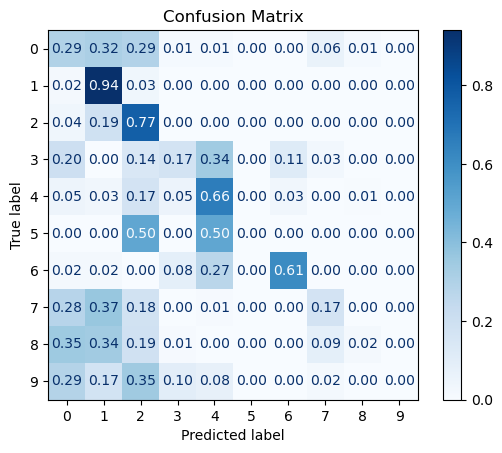

In [ ]:
# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy_knn:.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=knn_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(knn_model, X, y, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))

# Mean and std deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

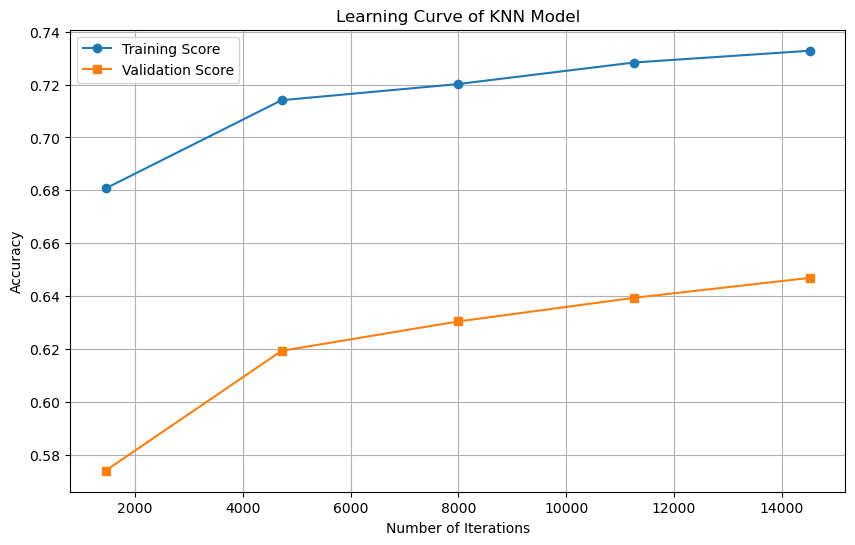

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='s')
plt.title("Learning Curve of KNN Model")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 10. Analyzing Color and Image Resolution
We ran tests to see how image scaling and removing color affexr 

In [ ]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd

def preprocess_images(images, color = True, size = (69, 69)):
    processed_images = []
    for img in images:
        if not color:
            img = np.mean(img, axis = -1)
        
        img_pil = Image.fromarray((img * 255).astype(np.uint8))

        if color:
            img_pil = img_pil.convert('RGB')
        else:
            img_pil = img_pil.convert('L')

        img_pil = img_pil.resize(size)
        img_resized = np.array(img_pil) / 255.0
        processed_images.append(img_resized)
    
    return np.array(processed_images)

def flatten_images(images):
    return images.reshape((images.shape[0], -1))

settings = [
    ("Color 69x69", True, (69, 69)),
    ("Grayscale 69x69", False, (69, 69)),
    ("Color 23x23", True, (23, 23)),
    ("Grayscale 23x23", False, (23, 23))
]

results = []

for title, is_color, shape in settings:
    print(f"\n===========================")
    print(f"Running: {title}")
    print(f"===========================")

    processed_imgs = preprocess_images(images, color = is_color, size = shape)

    processed_imgs = processed_imgs / 255.0

    flattened_imgs = flatten_images(processed_imgs)

    scaler = StandardScaler()
    flattened_imgs = scaler.fit_transform(flattened_imgs)

    X_train, X_test, y_train, y_test = train_test_split(flattened_imgs, labels, test_size=0.2, random_state=42, stratify=labels)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    start_time = time.time()
    rf.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print(f"Training Time: {elapsed_time:.2f} seconds")

    results.append({
        'Experiment': title,
        'Accuracy': acc,
        'Macro Precision': macro_precision,
        'Macro Recall': macro_recall,
        'Macro F1-Score': macro_f1,
        'Training Time (s)': elapsed_time
    })

results_df = pd.DataFrame(results)
display(results_df)


Running: Color 69x69


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7028
Macro Precision: 0.5358
Macro Recall: 0.4196
Macro F1-Score: 0.4177
Training Time: 76.87 seconds

Running: Grayscale 69x69


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4443
Macro Precision: 0.2051
Macro Recall: 0.1708
Macro F1-Score: 0.1618
Training Time: 73.79 seconds

Running: Color 23x23


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7147
Macro Precision: 0.5169
Macro Recall: 0.4229
Macro F1-Score: 0.4176
Training Time: 25.89 seconds

Running: Grayscale 23x23
Accuracy: 0.4283
Macro Precision: 0.2445
Macro Recall: 0.1563
Macro F1-Score: 0.1453
Training Time: 18.09 seconds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Experiment,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Training Time (s)
0,Color 69x69,0.702777,0.535809,0.419613,0.417668,76.865936
1,Grayscale 69x69,0.444342,0.205053,0.170770,0.161817,73.788895
2,Color 23x23,0.714712,0.516886,0.422851,0.417634,25.887630
3,Grayscale 23x23,0.428276,0.244515,0.156311,0.145292,18.089580


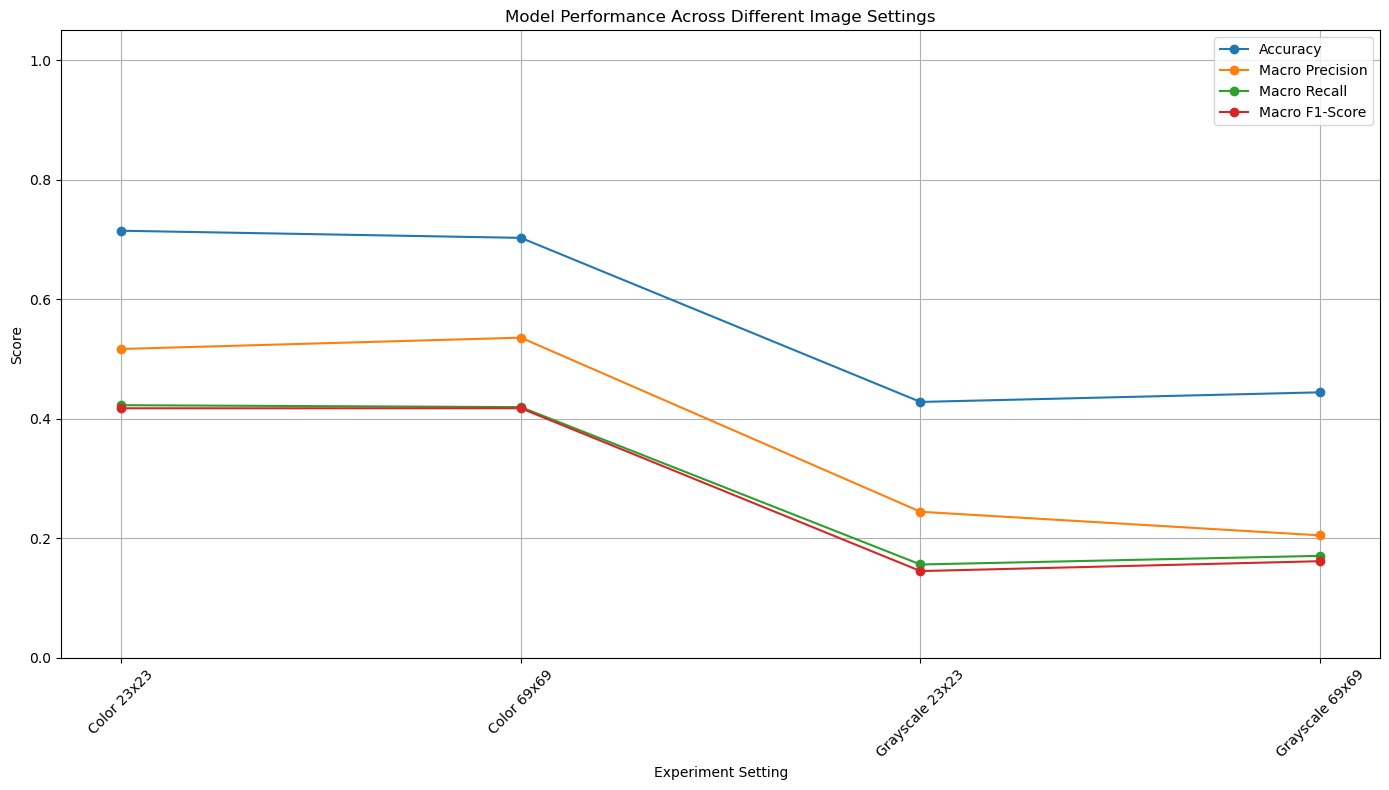

In [ ]:
# Plot
# Ensure the experiments are in a consistent order
results_df = results_df.sort_values(by='Experiment')

# Choose metrics to plot
metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']

plt.figure(figsize=(14, 8))

for metric in metrics:
    plt.plot(results_df['Experiment'], results_df[metric], marker='o', label=metric)

plt.title("Model Performance Across Different Image Settings")
plt.xlabel("Experiment Setting")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()